In [1]:
using MiniOps
using LinearAlgebra
using Plots, FFTW

In [2]:
function test_conv()

    h = randn(15)
    A = conv1d_op(h)

    x1 = randn(120) 
    y1 = A*x1
    
    y2 = randn(size(y1))
    x2 = A'*y2

println("<y1, y2> - <x1, x2>: ", y1'*y2 -x2'*x1)
println(A.name, " size : ", A.m, A.n)

end

test_conv()

<y1, y2> - <x1, x2>: 1.4210854715202004e-14
conv1d size : -1-1


In [7]:

function test_composition()

  println("Testing do-product for A = S1*R*S2")
  println("S1 is scaling")
  println("S2 applies diag weights")
  println("R is sampling")

    nx, ny = 20, 30
    full_size = (nx, ny)
    mask = rand(nx * ny) .> 0.7
    idx  = findall(mask)
    R = sampling_op(idx, full_size)

    S1 = scaling_op(3.0)
    S2 = diag_op(ones(nx,ny))

    A = S1*R*S2
    
    x1 = randn(nx, ny)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y2,y1))
println("name = ", A.name, " Size: ",  A.m, A.n)
end
    
test_composition()

Testing do-product for A = S1*R*S2
S1 is scaling
S2 applies diag weights
R is sampling
<x1,x2> = 50.75629529829088
<y1,y2> = 50.75629529829088
name = scaling*sampling*diag Size: -1-1


In [12]:
  # Multiple dispatch is used to generate two operators 

  A = fft_op(randn(ComplexF64,20,20))
  B = fft_op()

x1 = randn(ComplexF64,20,20)
y1 = A*x1

y2 = randn(ComplexF64,20,20)
x2 = A'*y2

println("<x1,x2> = ", round(dot(x1,x2), digits=8))
println("<y1,y2> = ", round(dot(y1,y2), digits=8))



A = with_shape(A, x1)
println(A.name,   "m :",  A.m, " n : ", A.n)
println(B.name,   "m :",  B.m, " n : ", B.n)

B = with_shape(B, x1)
println(B.name,   "m :",  B.m, " n : ", B.n)

<x1,x2> = -1.48552891 - 22.3818618im
<y1,y2> = -1.48552891 - 22.3818618im
fft_plannedm :400 n : 400
fft_opm :-1 n : -1
fft_opm :400 n : 400


In [14]:
function test_conv_multichannel()

    wavelet = rand(10)
    A = conv1d_cols_op(wavelet)

    x1 = randn(200,100)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y1,y2))
    
println(A.name," m : ", A.m, " n : ", A.n)

end
test_conv_multichannel()

<x1,x2> = 282.45742394984984
<y1,y2> = 282.4574239498496
conv1d_cols m : -1 n : -1


In [27]:
# demo Fourier reconstruction with SD 

    nx, ny= 256, 256
    full_size = (nx, ny)
    mask = rand(nx * ny) .> 0.9
    idx  = findall(mask)
    
 R = sampling_op(idx, full_size)
 F = fft_op(rand(nx,ny))

 x = zeros(ComplexF64,nx,ny)
 x[2,2] =     3.0 + im*3.0
 x[4,10] =  -3.0 - im*3.0
 x[10,4] =  -3.0 - im*3.0
 A = R*F
 DATA=F*x
 y = A*x
u0=randn(nx,ny)+im*randn(nx,ny)
e = opnorm_power(A,u0)
println(e)
μ = 0.1
ν = 0.98/e
u = ista(A, y, u0, μ, ν; niter=100, verbose=false);



1.0


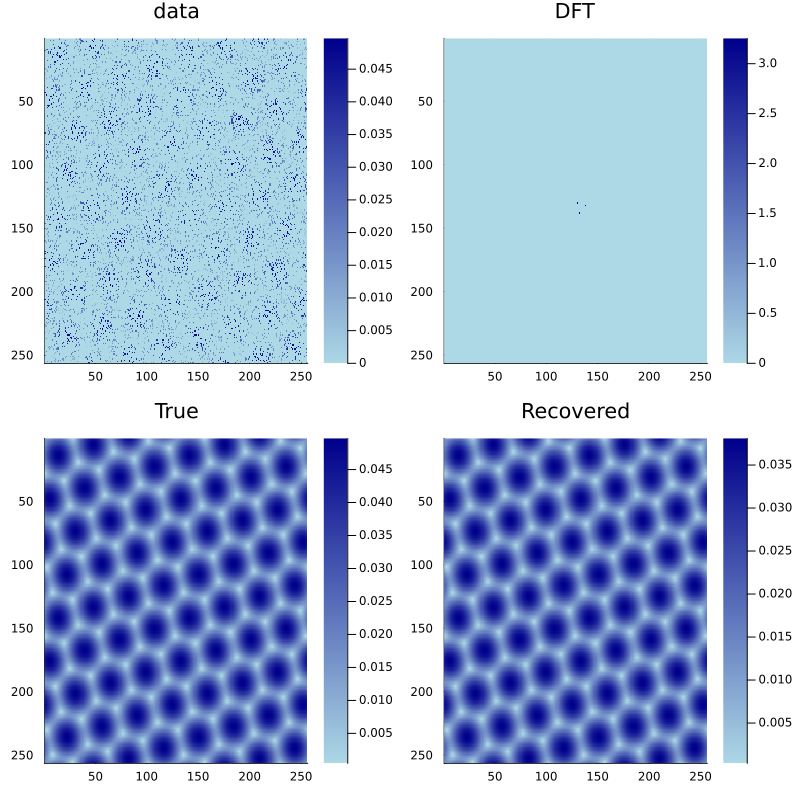

In [28]:

p1 = heatmap(abs.(R'*y), cmap=:blues, yflip=true, title="data")
p2 = heatmap(fftshift((abs.(u))),  cmap=:blues, yflip=true, title="DFT")
p3 = heatmap(abs.(DATA), cmap=:blues, yflip=true, title="True")
p4 = heatmap(abs.(F*u),  cmap=:blues, yflip=true, title="Recovered")
plot(p1, p2, p3, p4, layout = (2,2),size=(800,800))